In [46]:
import sys 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        pass
    

# **import libraries**

In [47]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import random
import cv2
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


# path

In [48]:
training ="/kaggle/input/skin-cancer-malignant-vs-benign/train"
testing="/kaggle/input/skin-cancer-malignant-vs-benign/test"
val_path="/kaggle/input/prediction-file"

# load data and vis 

In [49]:
#skin_cancer_data = train dataset  not all data
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)#This line tries to read all the subdirectories present 
labels_list #This code snippet only retrieves folder names, it doesn't access the actual image data.

['benign', 'malignant']

In [50]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)
#Extracting image filenames:
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)
print(images[0])
print(labels[0])

/kaggle/input/skin-cancer-malignant-vs-benign/train/benign/764.jpg
benign


In [51]:
import random

data = list(zip(images, labels))  # Combine images and labels into tuples
random.shuffle(data)

# Unpack shuffled data back into separate lists
images, labels = zip(*data)


In [52]:
print("Total images:", len(images))
print("Total labels:", len(labels))

Total images: 2637
Total labels: 2637


In [53]:
# convert fills to  table dataset 
#  'images' and 'labels' are your lists of images and labels 
df = pd.DataFrame({"images": images, "labels": labels})

# Creating a binary label column based on whether the label is "malignant" or not
df['label_binary'] = np.where(df["labels"].values == "malignant", 1, 0)

# Displaying the first few rows of the DataFrame
df.head()



,images,labels,label_binary
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0


In [54]:
df.tail()

,images,labels,label_binary
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0


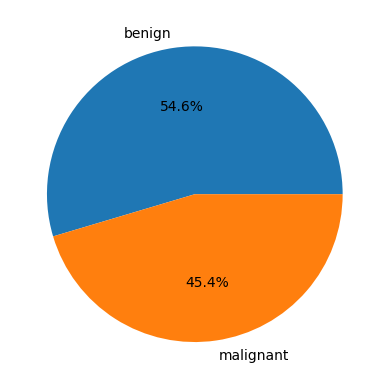

In [55]:
x = df['labels'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.1f%%')
plt.show()


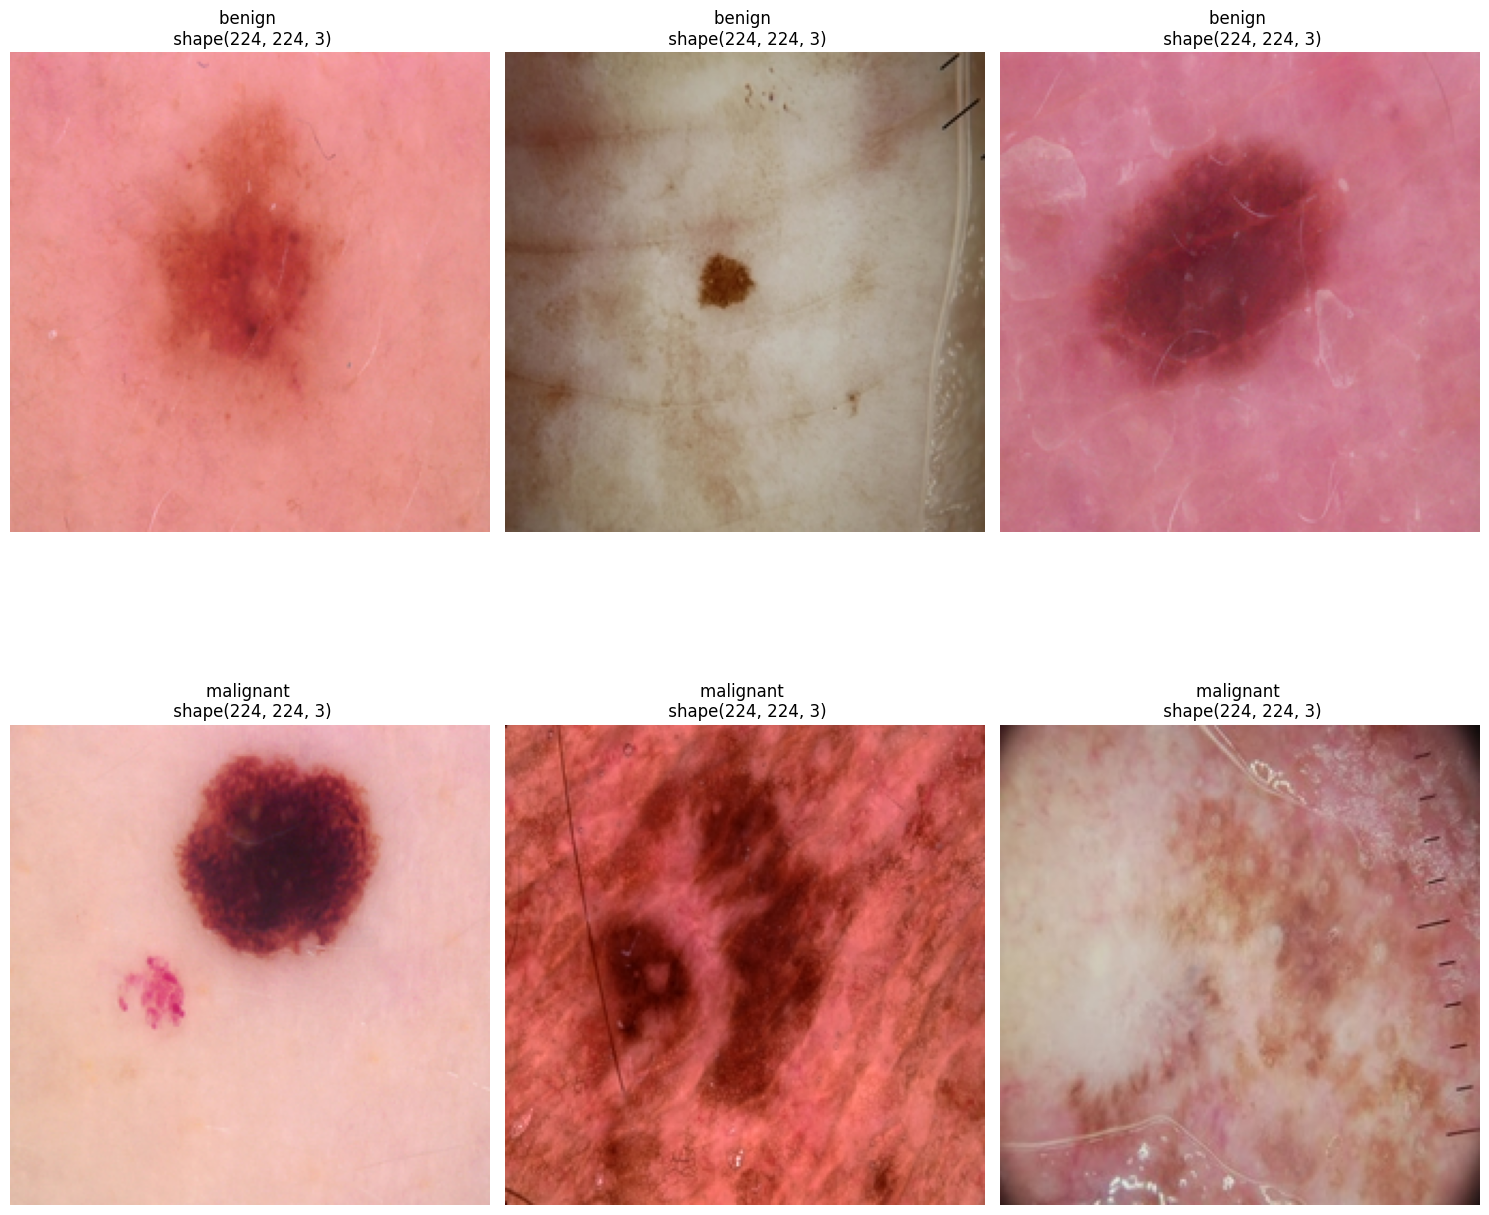

In [56]:
# display random images 
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:

    img=df["images"][df["labels"]==label]
    select_images= random.choices(img.values,k=3)

    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

# **Image Preprocessing And Augmentation **

In [57]:
#data preprocessing and augmentation during training 
#shear_range=0.2, This randomly applies a shearing transformation to the image.
#zoom_range=0.2, This randomly applies a zooming to the image. 
#horizontal_flip=True, This randomly applies  a horizontal and vertical flip 
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [58]:
# Load and preprocess training data
training_set = train_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/train',
                                                 target_size=(64,64),#resizes all images to a uniform size of 64x64 pixels.
                                                 batch_size=32,  #the number of images processed by the model at each training step
                                                 class_mode='binary')

# Load and preprocess test data
test_set = test_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/test',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [59]:
# the output  image shape  = (height,width,RGB)
training_set.image_shape

(64, 64, 3)

# Building CNN layers + NN 

In [60]:
# Define the model
model = Sequential()

# Convolutional layers
model.add(Convolution2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu', padding='same', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), activation='relu', padding='same', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=64, activation="relu"))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [61]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,150,273 (4.39 MB)

 Trainable params: 1,150,273 (4.39 MB)

 Non-trainable params: 0 (0.00 B)

None


# **Train the model**


In [62]:
#step_per_epoch= 1440(number of data-train)/ 32 (batch-size)
history = model.fit(training_set,
                    steps_per_epoch=45,
                    epochs=25,
                    validation_data=test_set)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.5946 - loss: 0.6582 - val_accuracy: 0.7076 - val_loss: 0.6160
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.7449 - loss: 0.5643 - val_accuracy: 0.7076 - val_loss: 0.5077
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.7519 - loss: 0.4941 - val_accuracy: 0.7470 - val_loss: 0.4836
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.7732 - loss: 0.4503 - val_accuracy: 0.7773 - val_loss: 0.4106
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.7880 - loss: 0.4070 - val_accuracy: 0.7864 - val_loss: 0.3986
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7815 - loss: 0.4176 - val_accuracy: 0.8015 - val_loss: 0.3832
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.8105 - loss: 0.4105 - val_accuracy: 0.8015 - val_loss: 0.3697
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.7783 - loss: 0.4313 - val_accuracy

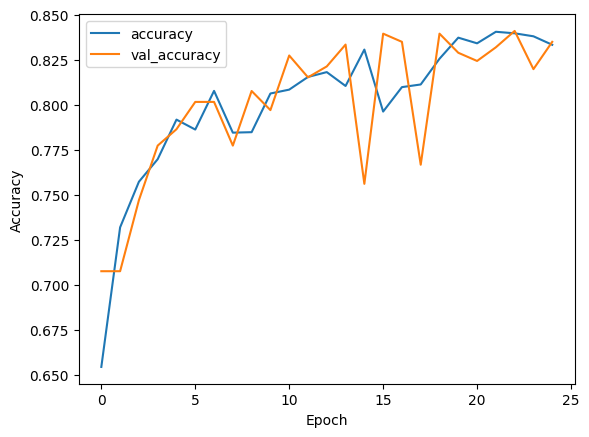

In [63]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Plot training history**

In [64]:
test_loss, test_acc = model.evaluate(test_set, steps=5)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8640 - loss: 0.2716
Test accuracy: 0.856249988079071
Test loss: 0.27530303597450256


# Testing

In [65]:
from keras.preprocessing import image
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/54.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
The prediction result is: malignant


In [66]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/b/18.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)#adds an extra dimension to the image array.

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The prediction result is: benign


# Evaluation

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score

# Evaluate model performance
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print(classification_report(y_true, y_pred))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

# Print F1-score
print("F1-score:", f1_score(y_true, y_pred))

# Print precision
print("Precision:", precision_score(y_true, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
              precision    recall  f1-score   support

           0       0.56      0.43      0.49       360
           1       0.46      0.59      0.52       300

    accuracy                           0.50       660
   macro avg       0.51      0.51      0.50       660
weighted avg       0.51      0.50      0.50       660

[[155 205]
 [124 176]]
F1-score: 0.5168869309838473
Precision: 0.46194225721784776
Accuracy: 0.5015151515151515
